## Plot the results of omega for a couple of samples

In [2]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress,norm
# import tabix
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
import sys
sys.path.append('../../')
from consensus_variables import *

In [4]:
pd.set_option('display.max_columns', None)

# Define gene order and plot and data directories

In [5]:
plots_dir = "plots"
data_dir = "data"

In [ ]:
def generate_all_side_figures(sample,
                              mut_file,
                              omega_file,
                              gene_list = None,
                              tools = ["omega_trunc", "omega_mis"],
                              plotts = plots_dir,
                              ymaximum = None,
                              between_text = 1.5,
                              withinbartext_off = 1.8,
                              text_off = 0.5,
                              remove_y_axis = False
                             ):

    snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values
                            )
    snvs_maf = snvs_maf[snvs_maf["TYPE"] == "SNV"].reset_index(drop = True)

    possible_genes = []

    omega_data = pd.read_table(omega_file)
    omega_data = omega_data[omega_data["impact"].isin(['missense', 'truncating'])]
    minimum_pvalue = omega_data[omega_data["pvalue"]>0]["pvalue"].min()
    if "omega_trunc" in tools :
        omega_truncating = omega_data[omega_data["impact"] == "truncating"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_truncating.columns = ["GENE", "mutations_trunc", "omega_trunc", "pvalue", "lower", "upper"]
        omega_truncating_genes = list(pd.unique(omega_truncating["GENE"]))
        possible_genes += omega_truncating_genes

    if "omega_mis" in tools :
        omega_missense = omega_data[omega_data["impact"] == "missense"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_missense.columns = ["GENE", "mutations_mis", "omega_mis", "pvalue", "lower", "upper"]
        omega_missense_genes = list(pd.unique(omega_missense["GENE"]))
        possible_genes += omega_missense_genes


    gene_list = list(set(possible_genes).intersection(set(gene_list)))


    # os.makedirs(f"{sample}.plots")

    for genee in gene_list:
        print(genee)
        try :
            if "omega_trunc" in tools:
                if genee in omega_truncating_genes and genee in omega_missense_genes:
                    omega_df = build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense)

                    fig_gene_omega = plot_omega_vertical(omega_df, ymaximum,
                                                            between_text = between_text,
                                                            withinbartext_off = withinbartext_off,
                                                            text_off = text_off,
                                                            no_y_axis = remove_y_axis,
                                                            min_pvalue = minimum_pvalue
                                                            )
                    fig_gene_omega.savefig(f"{plotts}/{genee}.{sample}.omega_side.pdf", bbox_inches='tight', dpi = 300)
                    plt.show()
                    plt.close()

        except Exception as exe:
            print(genee)
            print(exe)


In [ ]:
def build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense):

    trunc_omega = float(omega_truncating[omega_truncating["GENE"] == genee]["omega_trunc"].values[0])
    trunc_pvalue = float(omega_truncating[omega_truncating["GENE"] == genee]["pvalue"].values[0])

    miss_omega = float(omega_missense[omega_missense["GENE"] == genee]["omega_mis"].values[0])
    miss_pvalue = float(omega_missense[omega_missense["GENE"] == genee]["pvalue"].values[0])
    snvs_gene = snvs_maf[snvs_maf["canonical_SYMBOL"] == genee].reset_index(drop = True)


    # Calculate counts based on canonical consequences
    truncating_count = float(omega_truncating[omega_truncating["GENE"] == genee]["mutations_trunc"].values[0])
    missense_count = float(omega_missense[omega_missense["GENE"] == genee]["mutations_mis"].values[0])
    synonymous_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(["synonymous"])].shape[0]

    # Compute
    expected_missense = (1 - ((miss_omega - 1) / miss_omega)) * missense_count
    expected_truncating = (1 - ((trunc_omega - 1) / trunc_omega)) * truncating_count


    # Create a dataframe from the counts and expected values
    data = {
        'type': ['truncating', 'synonymous', 'missense'],
        'number_obs': [truncating_count, synonymous_count, missense_count],
        'expected': [expected_truncating, None, expected_missense],
        'omega': [trunc_omega, None, miss_omega],
        'pvalue': [trunc_pvalue, None, miss_pvalue]
    }
    df = pd.DataFrame(data)

    # Print the final dataframe
    return df

In [ ]:
def plot_omega_vertical(df, ymax = None,
                        bar_width=1,
                        figsize=(1, 1.23),
                        between_text = 1.5,
                        withinbartext_off = 1.8,
                        text_off = 0.5,
                        no_y_axis = False,
                        min_pvalue = 1e-6
                       ):
    
    consequence_order = ['truncating', 'missense']

    # Define colors
    colors = {
        'truncating': metrics_colors_dictionary["omega_trunc"],
        'missense': metrics_colors_dictionary["omega_miss"],
        'synonymous': metrics_colors_dictionary["omega_synon"]
    }

    # Filter relevant data
    df = df[df['type'].isin(consequence_order)]

    t_obs = df[df['type'] == 'truncating']['number_obs'].item()
    t_omega = df[df['type'] == 'truncating']['omega'].item()
    t_pvalue = df[df['type'] == 'truncating']['pvalue'].item()
    
    m_obs = df[df['type'] == 'missense']['number_obs'].item()
    m_omega = df[df['type'] == 'missense']['omega'].item()
    m_pvalue = df[df['type'] == 'missense']['pvalue'].item()
    
   # s_obs = df[df['type'] == 'synonymous']['number_obs'].item()  # Added synonymous mutations

    # Compute x positions for bars
    spacing_factor = bar_width * 1.1  # Adjust spacing based on bar width
    x_positions = np.arange(len(consequence_order)) * spacing_factor

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # **Matplotlib Barplot**
    ax.bar(x_positions,
           [t_obs, m_obs], 
           color=[colors[x] for x in consequence_order], 
           width=bar_width,
           edgecolor='none')

    # Overlay expected values as hatched bars (only for truncating & missense)
    for i, row in df.iterrows():
        if row['type'] != 'synonymous':  # No hatch for synonymous
            ax.bar(x_positions[consequence_order.index(row['type'])], row['expected'], 
                   color='none', edgecolor="black", hatch='//////',
                   linewidth=0,
                   width=bar_width)

    # Remove top/right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels([])

    if not no_y_axis:
        ax.set_ylabel('Number of mutations')

    # Positioning text annotations
    between_text_offset = max(max(df['number_obs']) * 0.05, between_text)
    text_offset = max(max(df['number_obs']) * 0.02, text_off)
    within_bar_text_offset = max(max(df['number_obs']) * 0.06, withinbartext_off)

    for i, row in df.iterrows():
        x_pos = x_positions[consequence_order.index(row['type'])]
        y_pos = row['number_obs'] + text_offset
        y_pos_low = row['number_obs'] - within_bar_text_offset
        omega_value = t_omega if row['type'] == 'truncating' else (m_omega if row['type'] == 'missense' else None)
        p_value = t_pvalue if row['type'] == 'truncating' else (m_pvalue if row['type'] == 'missense' else None)
        color = colors[row['type']]

        # Omega annotation (above the bar) - Only for truncating/missense
        if omega_value is not None:
            excess_mutss = row["number_obs"]*((omega_value-1)/omega_value)
            ax.text(x_pos, y_pos + between_text_offset,
                    # rf'$dN/dS$ = {omega_value:.2f}',
                    rf'dN/dS={omega_value:.2f}',
                    fontsize=plot_fontsizes_general_config["custom_text_fontsize"],
                    ha='center', va='bottom',
                    #color=color
                    color='black'
                   )

            # P-value annotation (below omega)
            ax.text(x_pos, y_pos,
                    f'$p$<{min_pvalue:.1e}' if p_value < min_pvalue else (f'$p$={p_value:.1e}' if p_value < 0.01 else f'$p$={p_value:.2f}'),
                    fontsize=plot_fontsizes_general_config["custom_text_fontsize"], ha='center', va='bottom',
                    #color=color
                    color='black'
                   )

            # Add excess mutations in bar
            if excess_mutss >= 1:
                ax.text(x_pos, y_pos_low,
                        f'{excess_mutss:.0f}',
                        fontsize=plot_fontsizes_general_config["custom_text_fontsize"], ha='center', va='bottom', color= 'black')

            
        else:
            mutations = row['number_obs']
            ax.text(x_pos,
                    y_pos,
                    #y_pos_low,
                    # rf'$dN/dS$ = {omega_value:.2f}',
                    rf'{mutations:.0f}',
                    fontsize=plot_fontsizes_general_config["custom_text_fontsize"], ha='center', va='bottom', color='gray')
        

    plt.legend(loc='best', frameon=False)

    if ymax is not None:
        plt.ylim(0,ymax)

    if not no_y_axis:
        ax.set_yticklabels(ax.get_yticklabels())
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])


    return fig


P19_0004_BDO_01
TP53


/tmp/ipykernel_4110776/1664951694.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_4110776/1664951694.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels())


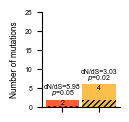

In [ ]:
# for sampleee in repeated_samples:
for sampleee in ['P19_0004_BDO_01',
                ]:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_all_side_figures(sample_name_,
                                mut_filee,
                                omega_filee,
                                ["TP53"],
                                # gene_order_positive_selection,
                                plotts= plots_dir,
                                ymaximum=25,
                                between_text = 2.2,
                                withinbartext_off = 1.8,
                                text_off = 0.3
                                )

P19_0009_BDO_01
TP53


/tmp/ipykernel_4110776/1664951694.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_4110776/1664951694.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels())


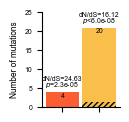

In [ ]:
# for sampleee in repeated_samples:
for sampleee in [#'P19_0004_BDO_01',
                # 'P19_0004_BTR_01',
                 'P19_0009_BDO_01',
                # 'P19_0009_BTR_01'
                ]:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_all_side_figures(sample_name_,
                                mut_filee,
                                omega_filee,
                                ["TP53"],
                                # gene_order_positive_selection,
                                plotts= plots_dir,
                                ymaximum=25,
                                between_text = 2.2,
                                withinbartext_off = 1.8,
                                text_off = 0.3,
                                remove_y_axis = False
                             )




P19_0004_BDO_01
RBM10


/tmp/ipykernel_4110776/1664951694.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_4110776/1664951694.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels())


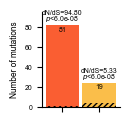

In [ ]:
for sampleee in ['P19_0004_BDO_01',
                ]:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_all_side_figures(sample_name_,
                                mut_filee,
                                omega_filee,
                                ["RBM10"],
                                # gene_order_positive_selection,
                                plotts= plots_dir,
                                ymaximum=95,
                                between_text = 8,
                                withinbartext_off = 7,
                                text_off = 0.2,
                             )


P19_0009_BDO_01
RBM10


/tmp/ipykernel_4110776/1664951694.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)
/tmp/ipykernel_4110776/1664951694.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels())


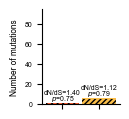

In [ ]:
plots_dir_vertical = f"{plots_dir}/vertical_complete"

# for sampleee in repeated_samples:
for sampleee in ['P19_0009_BDO_01',]:

    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_all_side_figures(sample_name_,
                              mut_filee,
                              omega_filee,
                              ["RBM10"],
                              # gene_order_positive_selection,
                              plotts= plots_dir,
                              ymaximum=95,
                              between_text = 8,
                              withinbartext_off = 7,
                              text_off = 0.2,
                              remove_y_axis = False
                             )


In [ ]:
def plot_omega_legend():
    # Use the same colors
    colors = {
        'truncating': metrics_colors_dictionary["omega_trunc"],
        'missense': metrics_colors_dictionary["omega_miss"],
    }

    # Bar handles (solid for observed mutations)
    bar_handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors['truncating'], label='Truncating'),
        plt.Rectangle((0, 0), 1, 1, color=colors['missense'], label='Missense')
    ]

    # Hatch handle (expected mutations)
    expected_patch = plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', hatch='//////', label='Expected')

    # Create figure
    fig_legend = plt.figure(figsize=(1.8, 0.6))  # Adjust as needed
    ax = fig_legend.add_subplot(111)
    ax.axis('off')

    # Create combined legend
    handles = bar_handles + [expected_patch]
    ax.legend(handles=handles, loc='center', frameon=False, ncol=3)

    return fig_legend


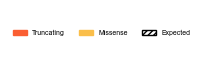

In [ ]:
fig = plot_omega_legend()
fig.savefig("plots/omega_legend.pdf", dpi=300, bbox_inches='tight')


## Indels barplot

In [ ]:
def generate_indels_figure(sample,
                              mut_file,
                              gene_list = None,
                              tools = ["omega_trunc", "omega_mis"],
                              plotts = plots_dir,
                              ymaximum = None,
                              between_text = 1.5,
                              withinbartext_off = 1.8,
                              text_off = 0.5,
                              remove_y_axis = False
                             ):

    indels_maf = pd.read_table(mut_file)
    indels_maf = indels_maf[indels_maf["TYPE"].isin(["INSERTION", "DELETION"])].reset_index(drop = True)
    
    indels_count = indels_maf.groupby( by = ["canonical_SYMBOL", "INDEL_INFRAME"] ).size().reset_index()
    indels_count.columns = ["GENE", "type", "number_obs"]
    indels_count["type"] = indels_count["type"].replace(True, 'inframe').replace(False, 'frameshift')
    
    possible_genes = []

    genes_with_info = list(pd.unique(indels_maf["canonical_SYMBOL"]))
    possible_genes += genes_with_info

    print(indels_count)
    # gene_list = list(set(possible_genes).intersection(set(gene_list)))


    # os.makedirs(f"{sample}.plots")

    for genee in gene_list:
        print(genee)
        # try :

        fig_gene_omega = plot_indels(indels_count[indels_count["GENE"] == genee],
                                     ymaximum,
                                     between_text = between_text,
                                     withinbartext_off = withinbartext_off,
                                     text_off = text_off,
                                     no_y_axis = remove_y_axis,
                                    )
        fig_gene_omega.savefig(f"{plotts}/{genee}.{sample}.indels.pdf", bbox_inches='tight', dpi = 300)
        plt.show()
        plt.close()

        # except Exception as exe:
        #     print(genee)
        #     print(exe)


In [ ]:
metrics_colors_dictionary = {"ofml"        : "viridis_r",
                             "ofml_score"  : "#6A33E0",
                             "omega_trunc" : "#FA5E32",
                             "omega_synon" : "#89E4A2",
                             "omega_miss"  : "#FABE4A",
                             "o3d_score"   : "#6DBDCC",
                             "o3d_cluster" : "skyblue",
                             "o3d_prob"    : "darkgray",
                             "frameshift"  : "#E4ACF4",
                             "inframe"     : "C5",
                             "hv_lines"    : "lightgray", # horizontal and vertical lines,
                             "hv_lines_needle" : "gray",
                             "needle_obs"  : "#003366",
                             "omega_miss_tert" : "#f5840c",
                             "omega_synon_tert": "#378c12",
                             "nonsense" : "#FA5E32",
                             "synonymous" : "#89E4A2",
                             "missense"  : "#FABE4A",
                             #"nonsense"    : "#FB8E6F",  
                             # "synonymous"  : "#ACECBD", 
                             #"missense"    : "#FBD180", 
                             "indel"       : "#ECC4F7", 
                             "splicing"    : "#A1C5DF",
                            }

In [ ]:
def plot_indels(df, ymax = None,
                        bar_width=0.2,
                        figsize=(0.6, 1.23),
                        between_text = 1.5,
                        withinbartext_off = 1.8,
                        text_off = 0.5,
                        no_y_axis = False,
                        min_pvalue = 1e-6
                       ):
    
    consequence_order = ['indels']

    # Define colors
    colors_dict = {
        'inframe': metrics_colors_dictionary["inframe"],
        'frameshift': metrics_colors_dictionary["frameshift"]
    }

    # Filter relevant data
    # df = df[df['type'].isin(consequence_order)]
    try :
        fsh_count = df[df['type'] == 'frameshift']['number_obs'].item()
    except : 
        fsh_count = 0
    try :
        inf_count = df[df['type'] == 'inframe']['number_obs'].item()
    except : 
        inf_count = 0
    
    total_obs = fsh_count + inf_count
    
    # Compute x positions for bars
    spacing_factor = bar_width * 1.1  # Adjust spacing based on bar width
    x_positions = np.arange(len(consequence_order)) * spacing_factor

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Initialize bottom positions for stacking
    bottom_values = 0

    for indel_type, valuee in [('frameshift', fsh_count),
                               ('inframe', inf_count)
                              ]:
        
        # Plot stacked bars
        ax.bar(x_positions,
               valuee,
               width=bar_width, label=indel_type.capitalize(), 
               color=colors_dict[indel_type], edgecolor='none', bottom=bottom_values)
        
        # Update bottom for next stack
        bottom_values += valuee

    
    # # **Matplotlib Barplot**
    # ax.bar(x_positions,
    #        [indel_obs], 
    #        color=[colors[x] for x in consequence_order], 
    #        width=bar_width,
    #        edgecolor='none')

    # Remove top/right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels([])
    # ax.set_yticks([])
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)

    
    ax.spines['left'].set_visible(False)
    
    if not no_y_axis:
        ax.set_ylabel('Number of mutations')

    # Positioning text annotations
    between_text_offset = max(total_obs * 0.05, between_text)
    text_offset = max(total_obs * 0.02, text_off)
    within_bar_text_offset = max(total_obs * 0.06, withinbartext_off)

    x_pos = x_positions[0]
    y_pos = total_obs + text_offset
    y_pos_low = total_obs - within_bar_text_offset
    color = 'black'

    # Add number of mutations in bar
    ax.text(x_pos, y_pos,
            f'{total_obs:.0f}',
            fontsize=plot_fontsizes_general_config["custom_text_fontsize"],
            ha='center', va='bottom', color= 'black')

    if ymax is not None:
        plt.ylim(0,ymax)

    if not no_y_axis:
        ax.set_yticklabels(ax.get_yticklabels())
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])


    return fig


In [6]:
def plot_indels_legend():
    # Match the same colors and labels as your main plot
    colors_dict = {
        'inframe': metrics_colors_dictionary["inframe"],
        'frameshift': metrics_colors_dictionary["frameshift"]
    }

    # Create dummy bars for the legend
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors_dict['frameshift'], label='Frameshift'),
        plt.Rectangle((0, 0), 1, 1, color=colors_dict['inframe'], label='Inframe')
    ]

    # Create figure
    fig_legend = plt.figure(figsize=(1.5, 0.5))  # Adjust size as needed
    ax = fig_legend.add_subplot(111)
    ax.axis('off')  # Turn off axes

    # Add legend
    ax.legend(handles=handles, loc='center', frameon=False, ncol=2)

    return fig_legend


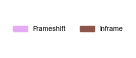

In [7]:
fig = plot_indels_legend()
fig.savefig("plots/indels_legend.pdf", dpi=300, bbox_inches='tight')


In [ ]:
# indels_table = pd.read_table(mut_filee)
# indels_table = indels_table[indels_table["TYPE"].isin(["INSERTION", "DELETION"])].reset_index(drop = True)
# indels_count = indels_table.groupby( by = ["canonical_SYMBOL", "INDEL_INFRAME"] ).size().reset_index()
# indels_count.columns = ["GENE", "IndelType", "Frequency"]
# indels_count["type"] = indels_count["IndelType"].replace(True, 'inframe').replace(False, 'frameshift')
# indels_count

P19_0004_BDO_01
      GENE        type  number_obs
0   ARID1A  frameshift          64
1   ARID1A     inframe           1
2   CDKN1A  frameshift          66
3   CREBBP  frameshift           8
4   CREBBP     inframe           2
5    EP300  frameshift          11
6    EP300     inframe           2
7    FGFR3  frameshift           2
8    FOXQ1  frameshift          22
9    FOXQ1     inframe           4
10    JPH3     inframe           1
11   KDM6A  frameshift         119
12   KMT2C  frameshift           1
13   KMT2D  frameshift         173
14   KMT2D     inframe           5
15   MAGI1     inframe           1
16   MAML2     inframe           2
17     MN1     inframe           1
18   NCOA3     inframe           1
19  NOTCH2  frameshift           4
20     RB1  frameshift           6
21     RB1     inframe           1
22   RBM10  frameshift          68
23   RBM10     inframe           1
24   STAG2  frameshift           6
25    TERT  frameshift           1
26    TP53  frameshift           1
TP53

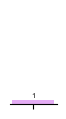

In [ ]:
# for sampleee in repeated_samples:
for sampleee in ['P19_0004_BDO_01',
                # 'P19_0004_BTR_01',
                # 'P19_0009_BDO_01',
                # 'P19_0009_BTR_01'
                ]:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)

    generate_indels_figure(sample_name_,
                           mut_filee,
                           ["TP53"],
                           # gene_order_positive_selection,
                           plotts= plots_dir,
                           ymaximum=25,
                           between_text = 1.5,
                           withinbartext_off = 1.8,
                           text_off = 0.5,
                           remove_y_axis = True
                           
                          )

P19_0009_BDO_01
      GENE        type  number_obs
0   ARID1A  frameshift           2
1    BMP2K     inframe           1
2   CREBBP  frameshift          23
3   CREBBP     inframe           1
4    EP300  frameshift          15
5    EP300     inframe           1
6    FOXQ1  frameshift           6
7    KDM6A  frameshift           2
8    KMT2C  frameshift           2
9    KMT2D  frameshift          15
10   MAGI1     inframe           1
11   MAML2     inframe           1
12  NOTCH2  frameshift           1
13  NOTCH2     inframe           2
14     RB1  frameshift           3
15     RB1     inframe           1
16   STAG2  frameshift           6
17   STAG2     inframe           1
18    TP53  frameshift           3
TP53


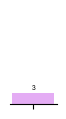

In [ ]:
# for sampleee in repeated_samples:
for sampleee in [#'P19_0004_BDO_01',
                # 'P19_0004_BTR_01',
                 'P19_0009_BDO_01',
                # 'P19_0009_BTR_01'
                ]:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_indels_figure(sample_name_,
                              mut_filee,
                              ["TP53"],
                              # gene_order_positive_selection,
                              plotts= plots_dir,
                              ymaximum=25,
                              between_text = 1.5,
                              withinbartext_off = 1.8,
                              text_off = 0.5,
                              remove_y_axis = True
                             )




P19_0004_BDO_01
      GENE        type  number_obs
0   ARID1A  frameshift          64
1   ARID1A     inframe           1
2   CDKN1A  frameshift          66
3   CREBBP  frameshift           8
4   CREBBP     inframe           2
5    EP300  frameshift          11
6    EP300     inframe           2
7    FGFR3  frameshift           2
8    FOXQ1  frameshift          22
9    FOXQ1     inframe           4
10    JPH3     inframe           1
11   KDM6A  frameshift         119
12   KMT2C  frameshift           1
13   KMT2D  frameshift         173
14   KMT2D     inframe           5
15   MAGI1     inframe           1
16   MAML2     inframe           2
17     MN1     inframe           1
18   NCOA3     inframe           1
19  NOTCH2  frameshift           4
20     RB1  frameshift           6
21     RB1     inframe           1
22   RBM10  frameshift          68
23   RBM10     inframe           1
24   STAG2  frameshift           6
25    TERT  frameshift           1
26    TP53  frameshift           1
RBM1

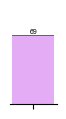

In [ ]:
# for sampleee in repeated_samples:
for sampleee in ['P19_0004_BDO_01',
                ]:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_indels_figure(sample_name_,
                              mut_filee,
                              ["RBM10"],
                              # gene_order_positive_selection,
                              plotts= plots_dir,
                              ymaximum=95,
                              between_text = 1.5,
                              withinbartext_off = 1.8,
                              text_off = 0.5,
                              remove_y_axis= True
                            )


P19_0009_BDO_01
      GENE        type  number_obs
0   ARID1A  frameshift           2
1    BMP2K     inframe           1
2   CREBBP  frameshift          23
3   CREBBP     inframe           1
4    EP300  frameshift          15
5    EP300     inframe           1
6    FOXQ1  frameshift           6
7    KDM6A  frameshift           2
8    KMT2C  frameshift           2
9    KMT2D  frameshift          15
10   MAGI1     inframe           1
11   MAML2     inframe           1
12  NOTCH2  frameshift           1
13  NOTCH2     inframe           2
14     RB1  frameshift           3
15     RB1     inframe           1
16   STAG2  frameshift           6
17   STAG2     inframe           1
18    TP53  frameshift           3
RBM10


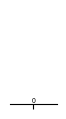

In [ ]:
plots_dir_vertical = f"{plots_dir}/vertical_complete"

# for sampleee in repeated_samples:
for sampleee in ['P19_0009_BDO_01',
                ]:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_indels_figure(sample_name_,
                              mut_filee,
                              ["RBM10"],
                              # gene_order_positive_selection,
                              plotts= plots_dir,
                              ymaximum=95,
                              between_text = 4,
                              withinbartext_off = 4,
                              text_off = 0.5,
                              remove_y_axis = True
                             )
